In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
"""Reading the simulations"""

import matplotlib.pyplot as plt 
import numpy as np
import pynbody


s=pynbody.load('/srv/cosmdatc/clues/B64_WM3_186592/LG/GAS_SFR/4096_Gasoline/1024/WMAP3.CLUES.HR.001024')
h = s.halos()

In [7]:
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import rotation as rot
import barstrength1 as strng
import kapparot as krot

#fo=open('/z/dalgorry/datos_salida/parametros.dat','w')
hh = 0.732
vector = (1,2,4)
r200 = (189.977454324, 173.656484976, 137.617865798)

for i in range(0,3):
    h1 = h[vector[i]]
    
    cen_pot = pynbody.analysis.halo.center(h1,mode='pot',retcen=True).in_units('kpc')

    xstr=(h1.star['pos'].in_units('kpc'))[:,0] - (cen_pot.in_units('kpc'))[0]
    ystr=(h1.star['pos'].in_units('kpc'))[:,1] - (cen_pot.in_units('kpc'))[1]
    zstr=(h1.star['pos'].in_units('kpc'))[:,2] - (cen_pot.in_units('kpc'))[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)    
        
    xgas=(h1.gas['pos'].in_units('kpc'))[:,0] - (cen_pot.in_units('kpc'))[0]
    ygas=(h1.gas['pos'].in_units('kpc'))[:,1] - (cen_pot.in_units('kpc'))[1]
    zgas=(h1.gas['pos'].in_units('kpc'))[:,2] - (cen_pot.in_units('kpc'))[2]
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
    xdrk=(h1.dm['pos'].in_units('kpc'))[:,0] - (cen_pot.in_units('kpc'))[0]
    ydrk=(h1.dm['pos'].in_units('kpc'))[:,1] - (cen_pot.in_units('kpc'))[1]
    zdrk=(h1.dm['pos'].in_units('kpc'))[:,2] - (cen_pot.in_units('kpc'))[2]
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    m_str = h1.star['mass'].in_units('Msol')
    m_gas = h1.gas['mass'].in_units('Msol')
    m_drk = h1.dm['mass'].in_units('Msol')
           
        
    rgal=0.15*r200[i]
        
    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])
        
    limit_gas = np.where(rgas<rgal)
    rgas_sort = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])
        
    Mc_str = cumsum((m_str[limit])[r_indice])
    M_gal = Mc_str[-1]
        
    Mc_gas = cumsum((m_gas[limit_gas])[rgas_indice])
    M_gas = Mc_gas[-1]
        
#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)
        
    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]
    
    print r50[-1], r90[-1], rgal, r200[i], 'radios'
             
#------------------masa total en r200 (Mvir)--------------------------
    rvir= concatenate([r,rgas,rdrk])
    mvir= concatenate([m_str, m_gas, m_drk])
        
    limit_vir = np.where(rvir<r200[i])
    rvir_sort = np.sort(rvir[limit_vir])
    rvir_indice = np.argsort(rvir[limit_vir])
        
    Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])
        
    M_vir = Mc_vir[-1]

    print M90[-1], M_gal, M_vir, M_gas ,'masas'
#-------------------------------------------------------------------            
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
    vel=(h1.star['vel'].in_units('km s**-1'))

    vxcm = sum(m_str[veloc]*vel[veloc,0])/sum(m_str[veloc])
    vycm = sum(m_str[veloc]*vel[veloc,1])/sum(m_str[veloc])
    vzcm = sum(m_str[veloc]*vel[veloc,2])/sum(m_str[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm
        
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(m_str,xstr,ystr,zstr,vx,vy,vz,r50[-1])
    
    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

        
    A2max, rmax = strng.a2max(m_str[corte], xn[corte], yn[corte], 20)
       
    k_rot = krot.kapa(m_str[corte], xn[corte], yn[corte], zn[corte],
                      vxn[corte], vyn[corte], vzn[corte])
    print A2max, rmax
    print k_rot
                       
    '''fo.write(#str('%s'% name)+'\t'+
            str('%12.6f'% r50[-1])+'\t'+
            str('%12.6f'% r90[-1])+'\t'+
            str('%12.6f'% rgal)+'\t'+
            str('%12.6f'% np.log10(M90[-1]))+'\t'+
            str('%12.6f'% np.log10(M_gal))+'\t'+
            str('%12.6f'% np.log10(M_gas))+'\t'+
            str('%12.6f'% np.log10(M_vir))+'\t'+
            str('%12.6f'% A2max)+'\t'+
            str('%12.6f'% rmax)+'\t'+
            str('%12.6f'% k_rot)+'\n')
    fo.flush()'''


0.881759274795 7.91317689287 28.4966181486 189.977454324 radios
10088476113.7 11209420927.6 640947101025.0 6618781224.06 masas
0.417909681005 0.571701313739
0.48733092094
2.3052000317 11.7806248266 26.0484727464 173.656484976 radios
9364799995.35 10405337025.3 489536262930.0 2070464032.32 masas
0.465155223343 0.601319677581
0.32374603106
2.63502981786 11.5162315525 20.6426798697 137.617865798 radios
4412506393.84 4902789767.94 243634724117.0 9292814784.76 masas
0.069287141529 0.582540736797
0.649479316176


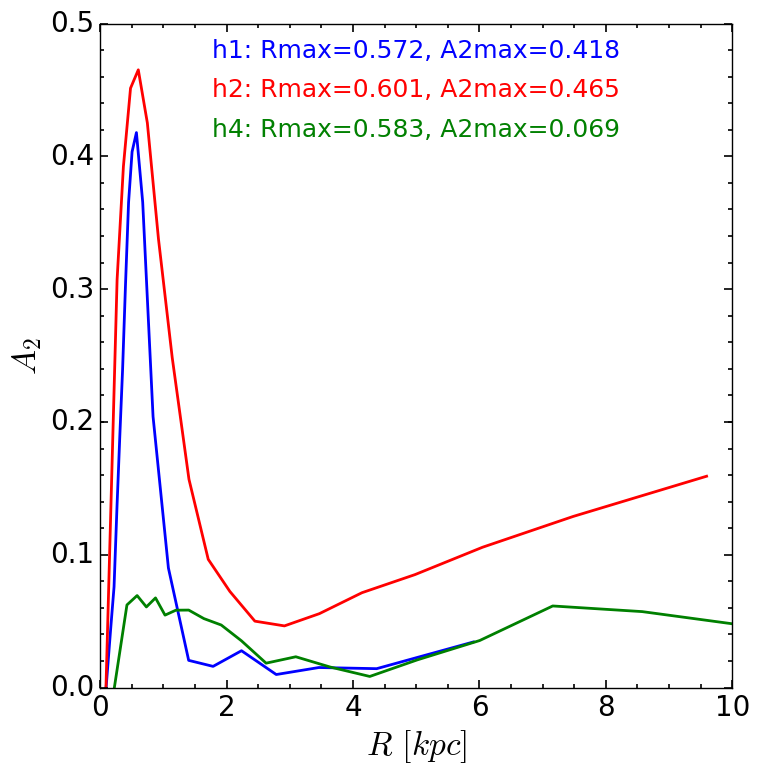

In [8]:
import matplotlib.pyplot as plt
import rotation as rot
import barstrength1 as strng

hh = 0.732
vector = (1,2,4)
vec2 = ('blue', 'red', 'green')
r200 = (189.977454324, 173.656484976, 137.617865798)

j=0

for i in range(0,3):
    h1 = h[vector[i]]
    
    cen_pot = pynbody.analysis.halo.center(h1,mode='pot',retcen=True)

    xstr=(h1.star['pos'].in_units('kpc'))[:,0] - (cen_pot.in_units('kpc'))[0]
    ystr=(h1.star['pos'].in_units('kpc'))[:,1] - (cen_pot.in_units('kpc'))[1]
    zstr=(h1.star['pos'].in_units('kpc'))[:,2] - (cen_pot.in_units('kpc'))[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)    
        
    m_str = h1.star['mass'].in_units('Msol')
        
    rgal=0.15*r200[i]
        
    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])
        
    Mc_str = cumsum((m_str[limit])[r_indice])
    M_gal = Mc_str[-1]
        
        
#------------------ calculamos R90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)
        
    r50 = r_sort[cincuenta]
    r90 = r_sort[noventa]              
                    
#---------------------------------------------------------------------------            
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])
        
#------------componentes de la velocidad del centro de masa------------------
    vel=(h1.star['vel'].in_units('km s**-1'))

    vxcm = sum(m_str[veloc]*vel[veloc,0])/sum(m_str[veloc])
    vycm = sum(m_str[veloc]*vel[veloc,1])/sum(m_str[veloc])
    vzcm = sum(m_str[veloc]*vel[veloc,2])/sum(m_str[veloc])
        
#-------velocidades de las estrellas respecto del centro de masa de la galaxia----
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm
        
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(m_str,xstr,ystr,zstr,vx,vy,vz,r50[-1])
    
    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
        
    A2max, rmax = strng.a2max(m_str[corte], xn[corte], yn[corte], 20)
        
    A2, phi, rbin = strng.a2(m_str[corte], xn[corte], yn[corte], 20)
        
    fig=plt.figure(1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax0=fig.add_subplot(111)
    ax0.plot(rbin,A2,'k', lw=2, color = '%s'%vec2[i])
    ax0.set_ylim(0,0.5)
    ax0.set_xlim(0,10)
    #ax0.set_title('subhalo_0'+ str('%s'%vector[i]), fontsize=24)
    ax0.set_xlabel(u'$R$ $[kpc]$', fontsize=24)
    ax0.set_ylabel(u'$A_2$', fontsize=24)
    ax0.minorticks_on()
    ax0.tick_params( labelsize=20)
    ax0.tick_params('both', length=3, width=1.2,which='minor')
    ax0.tick_params('both', length=6, width=1.2,which='major')
    plt.text(x = 5, y = 0.48-(0.03*j), 
             s ='h'+ str('%s'%vector[i])+': '+ 'Rmax=' +str('%.3f'%rmax)+', A2max=' + str('%.3f'%A2max),
             fontsize = 18, verticalalignment = 'center', horizontalalignment = 'center', 
             color = '%s'%vec2[i])
    j+=1

plt.show()

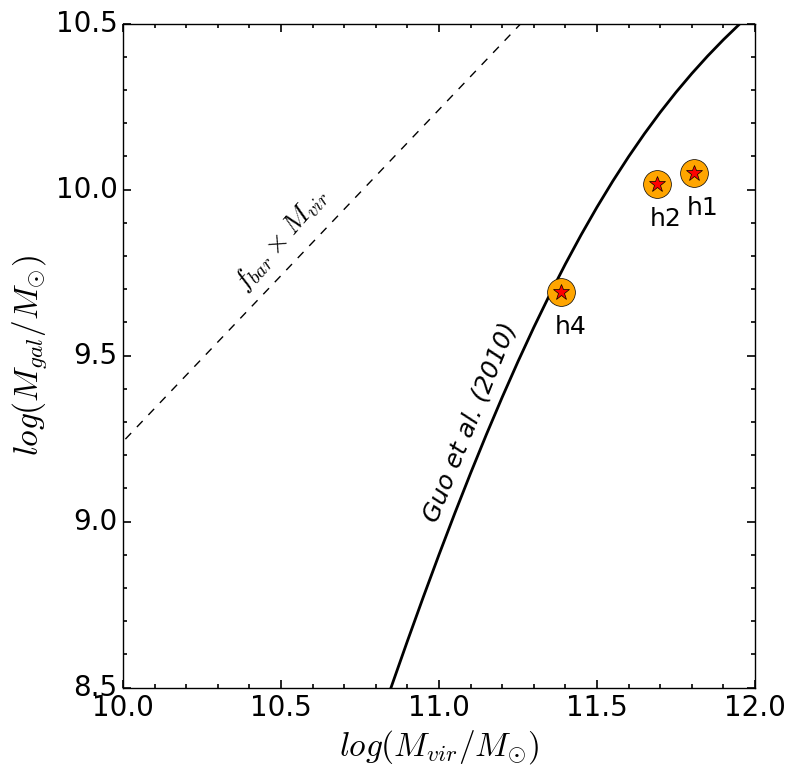

In [9]:
# Graficamos Mvir vs Mgal ##MODIFICADO
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/z/dalgorry/datos_salida/parametros.dat')

Mgal =cm[:,4]
Mvir =cm[:,6]
M90 =cm[:,3]
Mgas =cm[:,5]
  
c = 0.129
M0 = 10**11.4
alpha = 0.926
beta = 0.261
gamma = 2.440
MM = arange (10.5,12,0.05)
M_vir = 10**MM

vector = (1,2,4)

#------------------curva de Guo et al 2010-------------------
c1 = (M_vir/M0)**(-alpha)
c2 = (M_vir/M0)**beta
M_estrella = M_vir * c * ((c1+c2)**(-gamma))

Me=log10(M_estrella)

#-------fraccion de bariones universal--------------------
MM1 = arange (9.5, 12, 0.05)
fbar = 0.0418/0.24
Mbar = fbar * 10**MM1

#---------------------------------------------------------
fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(MM,Me,'k', lw=2)
ax1.plot(MM1,log10(Mbar),'--', lw=1, color ='k')
ax1.set_ylim(8.5,10.5)
ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=20)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_xlabel(r'$log(M_{vir}/M_{\odot})$', fontsize=24)
ax1.set_ylabel(r'$log(M_{gal}/M_{\odot})$', fontsize=24)
plt.text(x = 11.1, y = 9.3, s = u'Guo et al. (2010)', fontsize = 18, rotation= 68,  style='italic',
         verticalalignment = 'center', horizontalalignment = 'center')
plt.text(x = 10.5, y = 9.85, s = r'$f_{bar}\times M_{vir}$', fontsize = 20, rotation= 49,
         verticalalignment = 'center', horizontalalignment = 'center')


for i in range(0,3):
        ax1.plot(Mvir[i],Mgal[i],'o', markersize=20, color='orange')
        ax1.plot(Mvir[i],Mgal[i],'*', markersize=12, color='r')
        plt.annotate('h'+str('%s'%vector[i]), xy=(Mvir[i],Mgal[i]), 
                     xytext=(-5, -30), textcoords='offset points', fontsize=18)

plt.show()

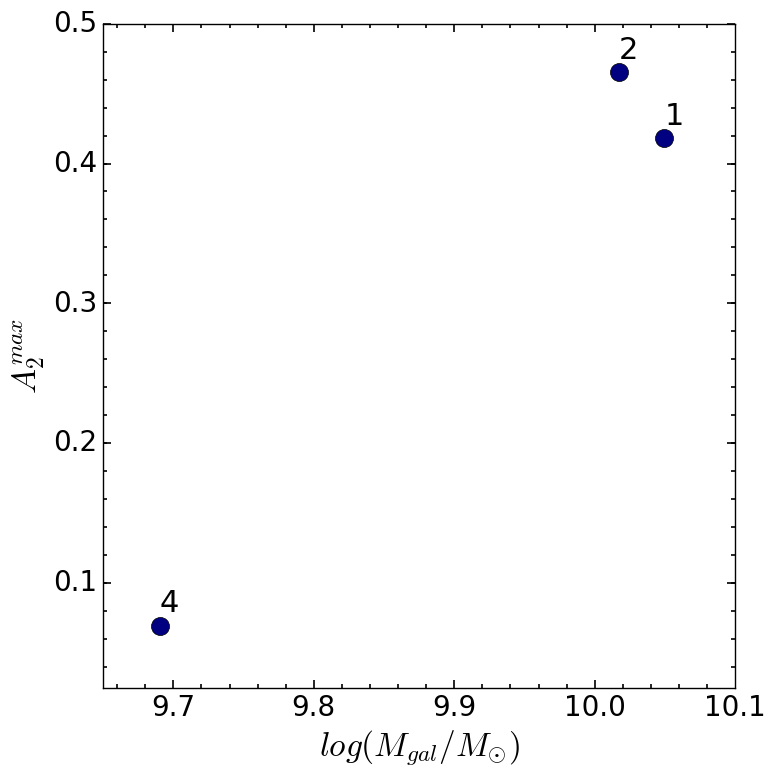

In [20]:
# Graficamos Mgal vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/z/dalgorry/datos_salida/parametros.dat')

Mgal =cm[:,4]
A2max=cm[:,7]

vector = (1,2,4)

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax2=fig.add_subplot(111)
ax2.plot(Mgal,A2max,'o', markersize=13, color='navy')
ax2.set_xlim(9.65,10.1)
ax2.set_ylim(0.025,0.5)
ax2.minorticks_on()
ax2.tick_params( labelsize=20)
ax2.tick_params('both', length=3, width=1.2,which='minor')
ax2.tick_params('both', length=6, width=1.2,which='major')  
plt.xlabel(r'$log(M_{gal}/M_{\odot})$', fontsize=24)
plt.ylabel(r'$A_{2}^{max}$',fontsize=24)
for i in range(0,3):
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],A2max[i]), 
                     xytext=(0, +10), textcoords='offset points', fontsize=22) 
plt.show()

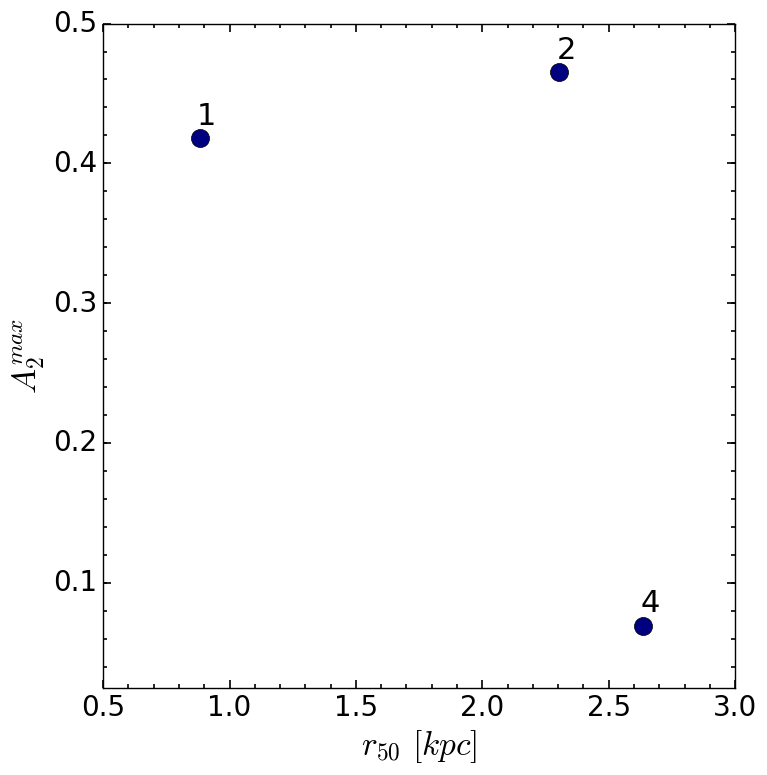

In [11]:
# Graficamos R50 vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/z/dalgorry/datos_salida/parametros.dat')

r50  =cm[:,0]
A2max=cm[:,7]


vector = (1,2,4)

fig=plt.figure(3, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(r50,A2max,'o', markersize=13, color='navy')
ax3.set_xlim(0.5,3.0)
ax3.set_ylim(0.025,0.5)
ax3.minorticks_on()
ax3.tick_params( labelsize=20)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
plt.xlabel(r'$r_{50}$ $[kpc]$', fontsize=24)
plt.ylabel(r'$A_{2}^{max}$',fontsize=24)
for i in range(0,3):
        plt.annotate('%s'% vector[i], xy=(r50[i],A2max[i]), 
                     xytext=(-2, +10), textcoords='offset points', fontsize=22)
plt.show()

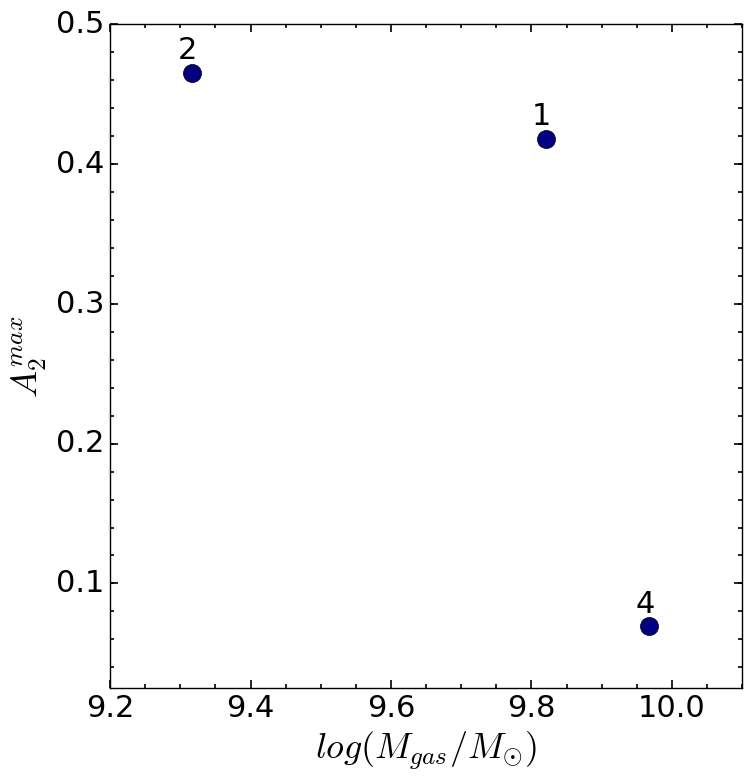

In [14]:
# Graficamos Mgas vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/z/dalgorry/datos_salida/parametros.dat')

Mgas =cm[:,5]
A2max=cm[:,7]

vector = (1,2,4)

fig=plt.figure(4, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(Mgas,A2max,'o', markersize=13, color='navy')
ax3.set_ylim(0.025,0.5)
ax3.set_xlim(9.2,10.1)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
ax3.set_xlabel(r'$log(M_{gas}/M_{\odot})$', fontsize=26)
ax3.set_ylabel(r'$A_{2}^{max}$',fontsize=26)
for i in range(0,3):
        plt.annotate('%s'% vector[i], xy=(Mgas[i],A2max[i]), 
                     xytext=(-10, +10), textcoords='offset points', fontsize=22)
plt.show()

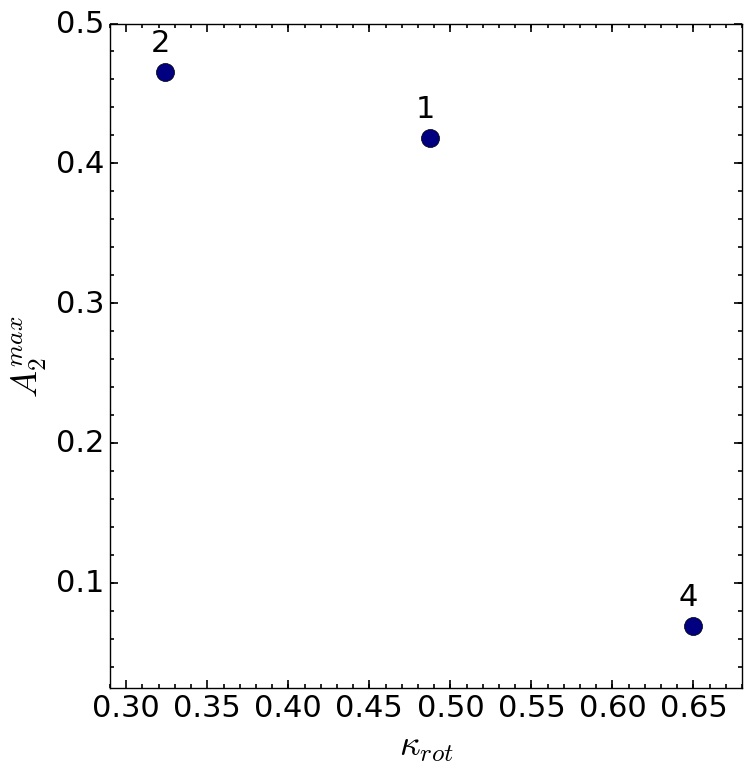

In [17]:
# Graficamos krot vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/z/dalgorry/datos_salida/parametros.dat')

A2max=cm[:,7]
krot =cm[:,9]

vector = (1,2,4)

fig=plt.figure(5, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(krot,A2max,'o', markersize=13, color='navy')
ax3.set_ylim(0.025,0.5)
ax3.set_xlim(0.29,0.68)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
ax3.set_xlabel(r'$\kappa_{rot}$', fontsize=26)
ax3.set_ylabel(r'$A_{2}^{max}$',fontsize=26)
for i in range(0,3):
        plt.annotate('%s'% vector[i], xy=(krot[i],A2max[i]), 
                     xytext=(-10, +15), textcoords='offset points', fontsize=22)

plt.show()


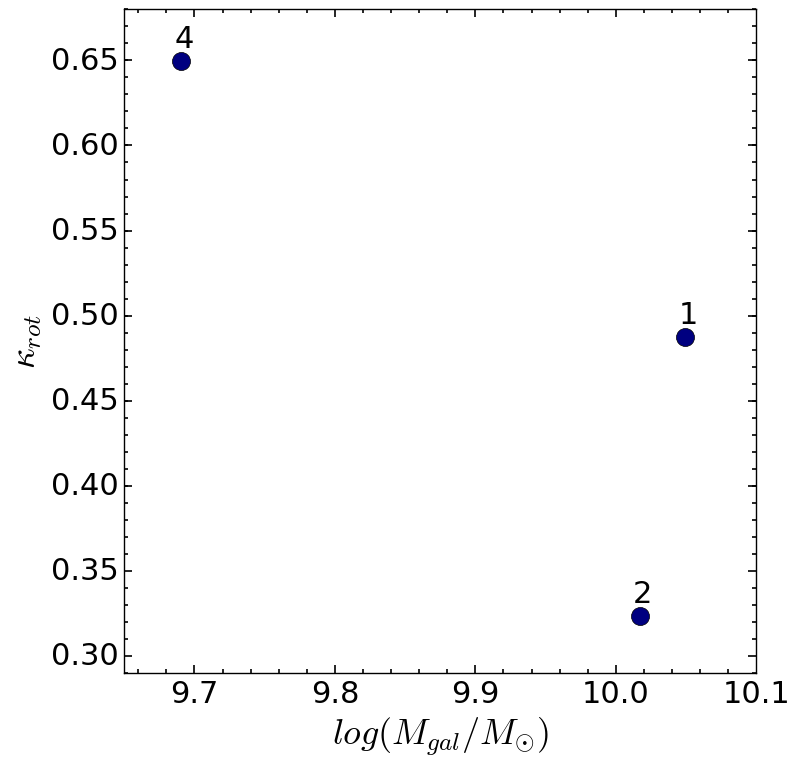

In [21]:
# Graficamos Mgal vs krot
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot
import matplotlib.pyplot as plt

cm=np.loadtxt('/z/dalgorry/datos_salida/parametros.dat')

Mgal =cm[:,4]
krot =cm[:,9]

vector = (1,2,4)

fig=plt.figure(6, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax3=fig.add_subplot(111)
ax3.plot(Mgal,krot,'o', markersize=13, color='navy')
ax3.set_xlim(9.65,10.1)
ax3.set_ylim(0.29,0.68)
ax3.minorticks_on()
ax3.tick_params( labelsize=22)
ax3.tick_params('both', length=3, width=1.2,which='minor')
ax3.tick_params('both', length=6, width=1.2,which='major')  
ax3.set_xlabel(r'$log(M_{gal}/M_{\odot})$', fontsize=26)
ax3.set_ylabel(r'$\kappa_{rot}$',fontsize=26)
for i in range(0,3):
        plt.annotate('%s'% vector[i], xy=(Mgal[i],krot[i]), 
                     xytext=(-5, +10), textcoords='offset points', fontsize=22)
plt.show()

In [6]:
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength1 as strng
import kapparot as krot

fo=open('/z/dalgorry/datos_salida2/param_galaxy.dat','w')
a0=1

vector = (1,2,4)
snapshot = np.loadtxt('/z/dalgorry/snapshots.txt', dtype='string')


for j in range(len(snapshot)-1,len(snapshot)-2,-1):
    #print j, snapshot[j]
    snap = h5py.File('../outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    
    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
        h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
        
        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value
        
        pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
        masa_gas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value
        
        pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
        masa_drk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value
        
        
#---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
        xgas = pgas[:,0]-cm[0]
        ygas = pgas[:,1]-cm[1]
        zgas = pgas[:,2]-cm[2]
        rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
        
        xdrk = pdrk[:,0]-cm[0]
        ydrk = pdrk[:,1]-cm[1]
        zdrk = pdrk[:,2]-cm[2]
        rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
         
        v_x = vel[:,0] 
        v_y = vel[:,1] 
        v_z = vel[:,2] 
        
#------------------------------------------------
        r200 = r200*aexp
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
        
        limit_gas = np.where(rgas<rgal)
        rgas_sort = np.sort(rgas[limit_gas])
        rgas_indice = np.argsort(rgas[limit_gas])
        
        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]
        
        Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
        M_gas = Mc_gas[-1]
        
#------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                
             
#------------------masa total en r200 (Mvir)--------------------------
        rvir= concatenate([r,rgas,rdrk])
        mvir= concatenate([masa_str, masa_gas, masa_drk])
        
        limit_vir = np.where(rvir<r200)
        rvir_sort = np.sort(rvir[limit_vir])
        rvir_indice = np.argsort(rvir[limit_vir])
        
        Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])
        
        M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
        corte1,=np.where(r<r90[-1])
        corte2,=np.where(r<2*r50[-1])
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*vel[veloc,0])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*vel[veloc,1])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*vel[veloc,2])/sum(masa_str[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])
    
        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz


        A2max, rmax = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)

        k_rot = krot.kapa(masa_str[corte1], xn[corte1], yn[corte1], zn[corte1],
                          vxn[corte1], vyn[corte1], vzn[corte1])
        #print A2max, rmax
        #print k_rot

        fo.write(#str('%s'% name)+'\t'+
                str('%12.6f'% r50[-1])+'\t'+
                str('%12.6f'% r90[-1])+'\t'+
                str('%12.6f'% rgal)+'\t'+
                str('%12.6f'% np.log10(M90[-1]))+'\t'+
                str('%12.6f'% np.log10(M_gal))+'\t'+
                str('%12.6f'% np.log10(M_gas))+'\t'+
                str('%12.6f'% np.log10(M_vir))+'\t'+
                str('%12.6f'% A2max)+'\t'+
                str('%12.6f'% rmax)+'\t'+
                str('%12.6f'% k_rot)+'\n')
        fo.flush()


### Grafico A2 vs rbin

In [3]:
#calculamos los parámetros de las galaxias 
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot

import matplotlib.pyplot as plt
import h5py
import rotation as rot
import barstrength1 as strng
import kapparot as krot

a0=1

vector = (1,2,4)
vec2 = ('blue', 'red', 'green')
vector3 = ('M31','MW','M33')
snapshot = np.loadtxt('/home/ornela/SimCLUES/Gasoline/snapshots.txt', dtype='string')

snap = h5py.File('/home/ornela/SimCLUES/Gasoline/outputs2/snap_1024.h5py', 'r')
j=0    
for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    pgas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Coordinates'].value
    masa_gas = snap['subhalo_00'+ str('%s' %vector[i])+ '/Gas/Masses'].value

    pdrk = snap['subhalo_00'+ str('%s' %vector[i]) + '/Drk/Coordinates'].value
    masa_drk = snap['subhalo_00'+ str('%s' %vector[i])+ '/Drk/Masses'].value

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    xgas = pgas[:,0]-cm[0]
    ygas = pgas[:,1]-cm[1]
    zgas = pgas[:,2]-cm[2]
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)

    xdrk = pdrk[:,0]-cm[0]
    ydrk = pdrk[:,1]-cm[1]
    zdrk = pdrk[:,2]-cm[2]
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)

    v_x = vel[:,0] 
    v_y = vel[:,1]
    v_z = vel[:,2] 

#------------------------------------------------
    r200 = r200*aexp
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    limit_gas = np.where(rgas<rgal)
    rgas_sort = np.sort(rgas[limit_gas])
    rgas_indice = np.argsort(rgas[limit_gas])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

    Mc_gas = cumsum((masa_gas[limit_gas])[rgas_indice])
    M_gas = Mc_gas[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------
    rvir= concatenate([r,rgas,rdrk])
    mvir= concatenate([masa_str, masa_gas, masa_drk])

    limit_vir = np.where(rvir<r200)
    rvir_sort = np.sort(rvir[limit_vir])
    rvir_indice = np.argsort(rvir[limit_vir])

    Mc_vir = cumsum((mvir[limit_vir])[rvir_indice])

    M_vir = Mc_vir[-1]

#-------------------------------------------------------------------            
    corte1,=np.where(r<rgal)
    corte2,=np.where(r<2*r50[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*vel[veloc,0])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*vel[veloc,1])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*vel[veloc,2])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz


    A2max, rmax = strng.a2max(masa_str[corte2], xn[corte2], yn[corte2], 20)

    A2, phi, rbin = strng.a2(masa_str[corte1], xn[corte1], yn[corte1], 20)
    
#----------------------------------------------------------------------------------
    data = np.ndarray([np.size(A2),2])
    data[:,0] = A2
    data[:,1] = rbin

    np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector3[i])+'_A2vsR.dat', data, fmt=['%12.6f','%12.6f'])
        
    

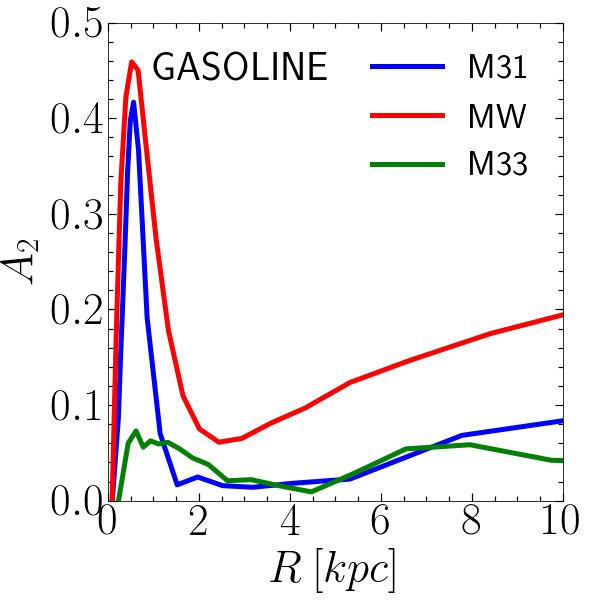

In [6]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

cm1 = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/M31_A2vsR.dat')
M31_A2   = cm1[:,0]
M31_rbin = cm1[:,1]

cm2 = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/MW_A2vsR.dat')
MW_A2   = cm2[:,0]
MW_rbin = cm2[:,1]

cm3 = np.loadtxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/M33_A2vsR.dat')
M33_A2   = cm3[:,0]
M33_rbin = cm3[:,1]

fig = plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax=fig.add_subplot(111)
Andromeda, = ax.plot(M31_rbin,M31_A2,'-', lw=5, color='b')
Via_Lactea, = ax.plot(MW_rbin,MW_A2,'-', lw=5, color='r')
Triangulo, = ax.plot(M33_rbin,M33_A2,'-', lw=5, color='g')
ax.set_ylim(0,0.5)
ax.set_xlim(0,10)
#ax0.set_title('subhalo_0'+ str('%s'%vector[i]), fontsize=24)
ax.set_xlabel(r'$R\:[kpc]$', fontsize=45)
ax.set_ylabel(r'$A_2$', fontsize=45)
ax.minorticks_on()
ax.set_xticks([0,2,4,6,8,10])
ax.tick_params( labelsize=45)
ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')#,colors='w')
ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')#,colors='w')  
ax.text(1,0.45,'GASOLINE', color='k',fontsize=40, ha='left', va='center', fontweight='bold',family='cursive')

#         plt.text(x = 1.2, y = 0.41-(0.05*j), 
#                  s =str('%s'%vector3[i])+': '+ '$R_{max}=$' +str('%.3f'%rmax)+ ' $A_{2}^{max}=$' + str('%.3f'%A2max),
#                  fontsize = 30, va= 'center', ha= 'left', color = '%s'%vector2[i])
ax.legend([Andromeda, Via_Lactea, Triangulo],['M31', 'MW', 'M33'],fontsize=35, frameon=False, loc=1)
        
fig.savefig('/home/ornela/Dropbox/AAA_2017/escrito/BAAA_2018_art/fig_03.pdf', dpi = 100,bbox_inches='tight',pad_inches=0.1)
        
#fig.savefig('r_vs_A2.png', dpi = 80)
plt.show()